<a id="a7a"></a>
## Popularity Based Recommender Model

A popularity-based recommendation system focuses on trending items, ranking them according to their popularity, which is determined by the number of ratings they receive. Products with high ratings are typically placed higher in the ranking and are more likely to be recommended. Since this approach relies on the general popularity of products, it lacks personalization, resulting in the same group of products being suggested to all users.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
products = '/content/drive/My Drive/ratings_filtered.csv'

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_color_codes()
sns.set(style="whitegrid")
%matplotlib inline
from scipy.stats import zscore
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from math import sqrt

In [ ]:
import pandas as pd
import io

products = pd.read_csv(products, names=['userId', 'productId', 'Rating','timestamp'], header=None)

# Now the 'electronics' DataFrame should be the same as if you had read it from the local file 'ratings_Electronics.csv'
print(products.head())

           userId   productId  Rating   timestamp
0   AKM1MP6P0OYPR  0132793040     5.0  1365811200
1  A2CX7LUOHB2NDG  0321732944     5.0  1341100800
2  A2NWSAGRHCP8N5  0439886341     1.0  1367193600
3  A2WNBOD3WNDNKT  0439886341     3.0  1374451200
4  A1GI0U4ZRJA8WN  0439886341     1.0  1334707200


In [ ]:
products.drop('timestamp', axis=1, inplace=True)

In [ ]:

# import packages
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:

train_data, test_data = train_test_split(products, test_size =.30, random_state=10)
print('Training and Testing Set Distribution')

print(f'Training set has {train_data.shape[0]} rows and {train_data.shape[1]} columns')
print(f'Testing set has {test_data.shape[0]} rows and {test_data.shape[1]} columns')

Training and Testing Set Distribution
Training set has 5477137 rows and 3 columns
Testing set has 2347345 rows and 3 columns


In [ ]:
#nitializes the popularity_based_recommender_model class with training data, test data, user ID, and item ID.
#It also sets an attribute for storing the popularity-based recommendations, which is initially None.
class popularity_based_recommender_model():
    def __init__(self, train_data, test_data, user_id, item_id):
        self.train_data = train_data
        self.test_data = test_data
        self.user_id = user_id
        self.item_id = item_id
        self.popularity_rec = None

    #Create the popularity based recommender system model
    def fit(self):
        #Get a count of user_ids for each unique product as recommendation score
        train_data_grouped = train_data.groupby([self.item_id]).agg({self.user_id: 'count'}).reset_index()
        train_data_grouped.rename(columns = {'userId': 'score'},inplace=True)

        #Sort the products based upon recommendation score
        train_data_sort = train_data_grouped.sort_values(['score', self.item_id], ascending = [0,1])

        #Generate a recommendation rank based upon score
        train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first')

        #Get the top 10 recommendations
        self.popularity_rec = train_data_sort.head(20)

    #Uses the popularity-based model to recommend items to a specific user. It filters out items that the user has already
    #rated and selects the top n (default 5) recommendations for that user. It also visualizes these recommendations using the plot method before returning them.
    def recommend(self, user_id, n=5):
        user_rec= self.popularity_rec

        #Filter products that are not rated by the user
        products_rated_by_user = self.train_data[self.train_data[self.user_id] == user_id][self.item_id]
        user_rec = user_rec[~user_rec[self.item_id].isin(products_rated_by_user)]

        #Add user_id column for which the recommendations are being generated
        user_rec['user_id'] = user_id

        #Bring user_id column to the front
        cols = user_rec.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        user_rec = user_rec[cols].head(n)
        self.plot(user_rec)
        return user_rec

    def plot(self, user_rec):
        f, axes = plt.subplots(1, 2, figsize=(20, 8))
        plot1 = sns.barplot(x='Rank', y='score', data=user_rec, hue='Rank', ax=axes[0])
        plot1.set_xlabel('Rank',fontsize=20)
        plot1.set_ylabel('score',fontsize=20)
        plot2 = sns.pointplot(x='Rank', y='score', data=user_rec, hue='Rank', ax=axes[1])
        plot2.set_xlabel('Rank',fontsize=20)
        plot2.set_ylabel('score',fontsize=20)

    def predict_evaluate(self):
      #Evaluates the performance of the recommender system using the test data. It predicts ratings for the test data items based on their average
      #ratings in the training data. The method then calculates and returns the root mean squared error (RMSE) between the predicted and actual ratings
      #in the test data, providing a measure of the model's accuracy.
        ratings = pd.DataFrame(self.train_data.groupby(self.item_id)['Rating'].mean())

        pred_ratings = [];
        for data in self.test_data.values:
            if(data[1] in (ratings.index)):
                pred_ratings.append(ratings.loc[data[1]])
            else:
                pred_ratings.append(0)

        var2 = np.asarray(self.test_data['Rating'], dtype="object")
        var1 = np.asarray(pred_ratings, dtype="object")

        mse = mean_squared_error(var2, var1)
        rmse = sqrt(mse)
        return rmse
    # def predict_evaluate(self):
    #     # Compute the average ratings in the training set.
    #     ratings = self.train_data.groupby(self.item_id)['Rating'].mean()

    #     pred_ratings = []
    #     for data in self.test_data.values:
    #         item_id = data[1]
    #         user_rating = ratings.get(item_id, 0)  # Default to np.nan if item_id is not found
    #         pred_ratings.append(user_rating)

    #     # Handle missing values (nan) by imputing a default value, e.g., the global mean.
    #     if np.nan in pred_ratings:
    #         global_mean = self.train_data['Rating'].mean()
    #         pred_ratings = [rating if not np.isnan(rating) else global_mean for rating in pred_ratings]

    #     # Convert to numpy array ensuring all values are floats.
    #     pred_ratings = np.array(pred_ratings, dtype=float)

    #     # Make sure that the actual ratings are also in the correct format.
    #     actual_ratings = np.array(self.test_data['Rating'], dtype=float)

    #     # Now compute the mean squared error.
    #     mse = mean_squared_error(actual_ratings, pred_ratings)
    #     rmse = sqrt(mse)

    #     return rmse








In [ ]:
#Initialize the recommender model with train and test data
pr = popularity_based_recommender_model(train_data=train_data, test_data=test_data, user_id='userId', item_id='productId')

In [ ]:
pr.fit()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

**Recommendations: Trying with three different Users**

,user_id,productId,score,Rank
271616,A1H8PY3QHMQQA0,B0074BW614,12758,1.0
375273,A1H8PY3QHMQQA0,B00DR0PDNE,11418,2.0
287906,A1H8PY3QHMQQA0,B007WTAJTO,9982,3.0
91705,A1H8PY3QHMQQA0,B0019EHU8G,8599,4.0
261349,A1H8PY3QHMQQA0,B006GWO5WK,8498,5.0


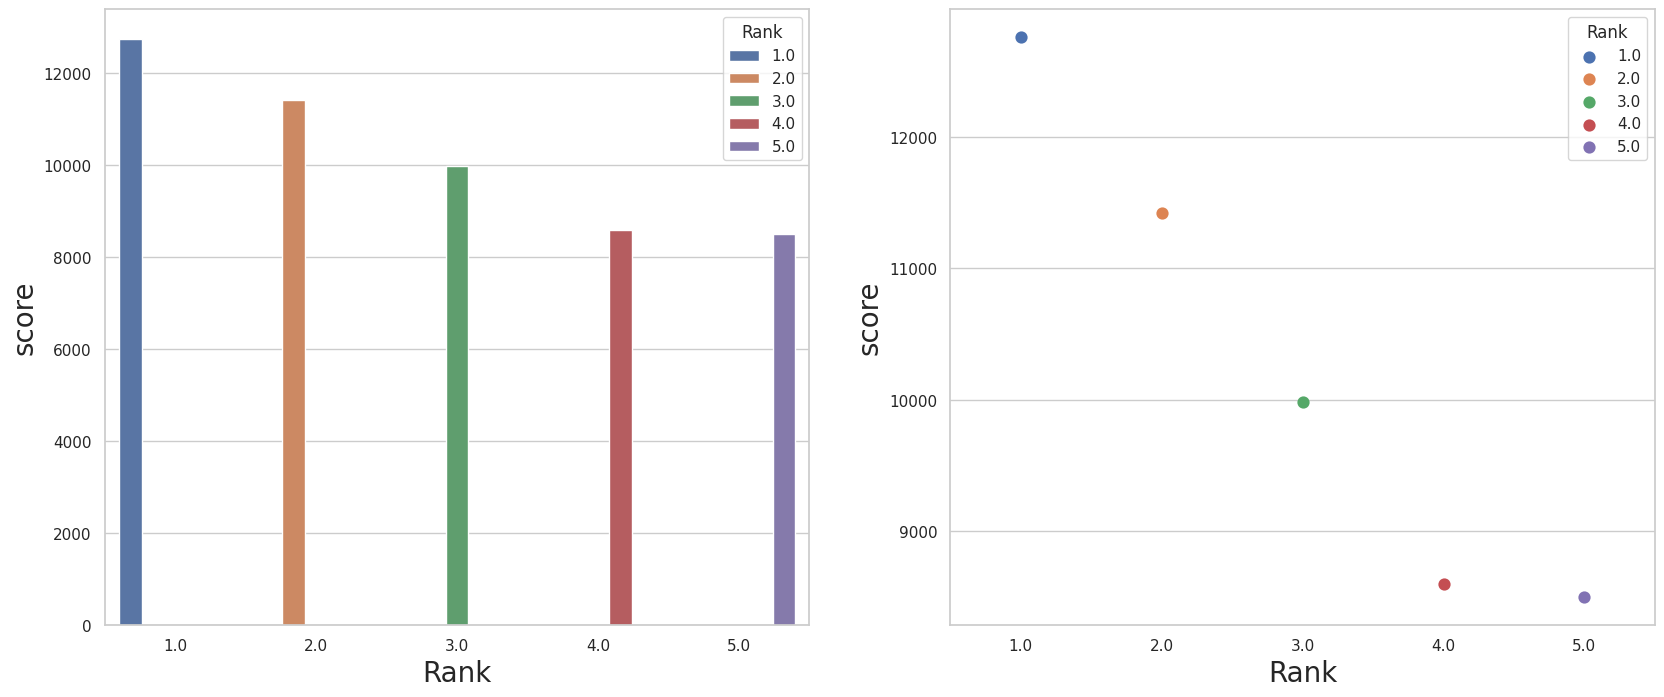

In [ ]:
result_user1 = pr.recommend('A1H8PY3QHMQQA0')
result_user1

,user_id,productId,score,Rank
271616,A1JLEDHBYBOLG2,B0074BW614,12758,1.0
375273,A1JLEDHBYBOLG2,B00DR0PDNE,11418,2.0
287906,A1JLEDHBYBOLG2,B007WTAJTO,9982,3.0
91705,A1JLEDHBYBOLG2,B0019EHU8G,8599,4.0
261349,A1JLEDHBYBOLG2,B006GWO5WK,8498,5.0


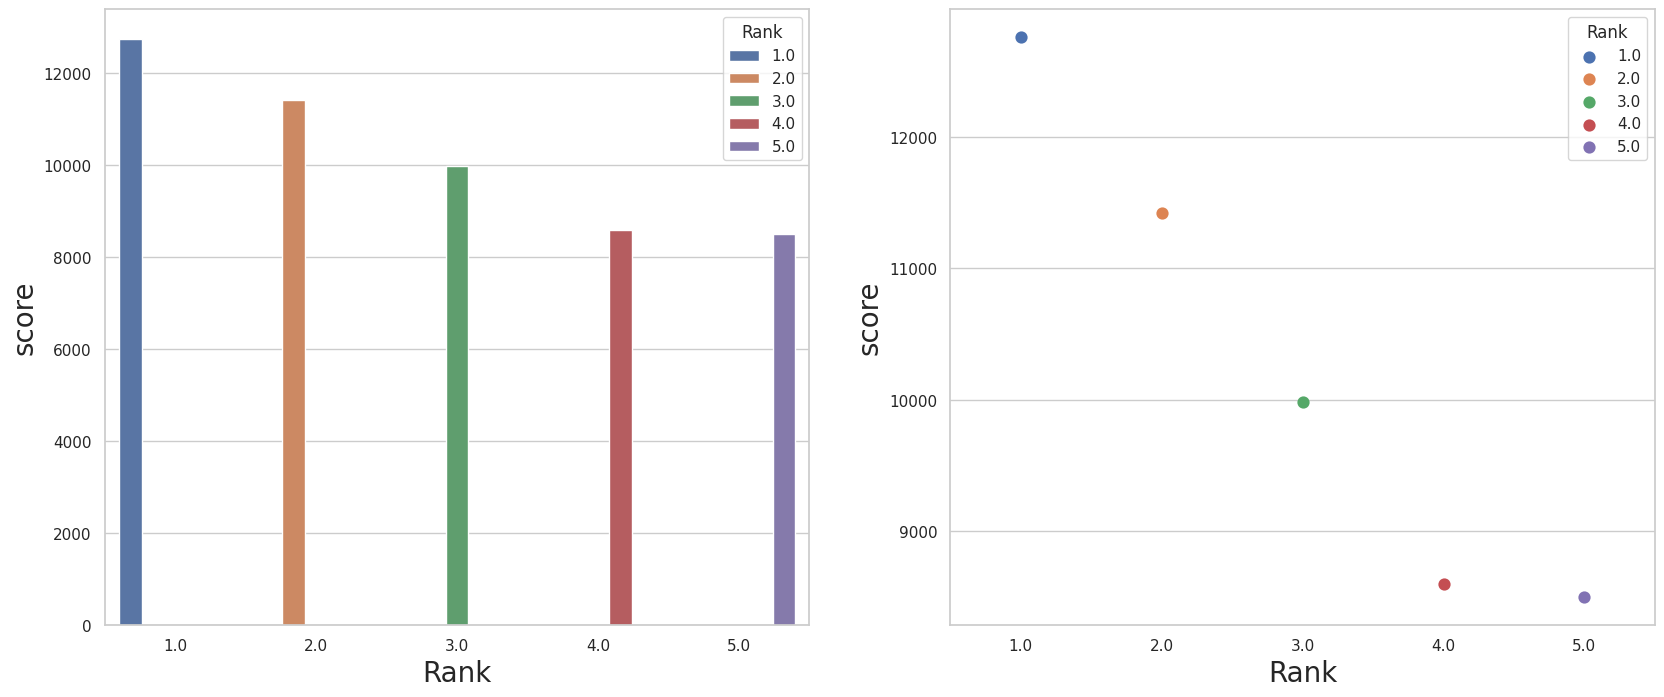

In [ ]:
result_user2 = pr.recommend('A1JLEDHBYBOLG2')
result_user2

,user_id,productId,score,Rank
271616,A169NZ5I5UQLRY,B0074BW614,12758,1.0
375273,A169NZ5I5UQLRY,B00DR0PDNE,11418,2.0
287906,A169NZ5I5UQLRY,B007WTAJTO,9982,3.0
91705,A169NZ5I5UQLRY,B0019EHU8G,8599,4.0
261349,A169NZ5I5UQLRY,B006GWO5WK,8498,5.0


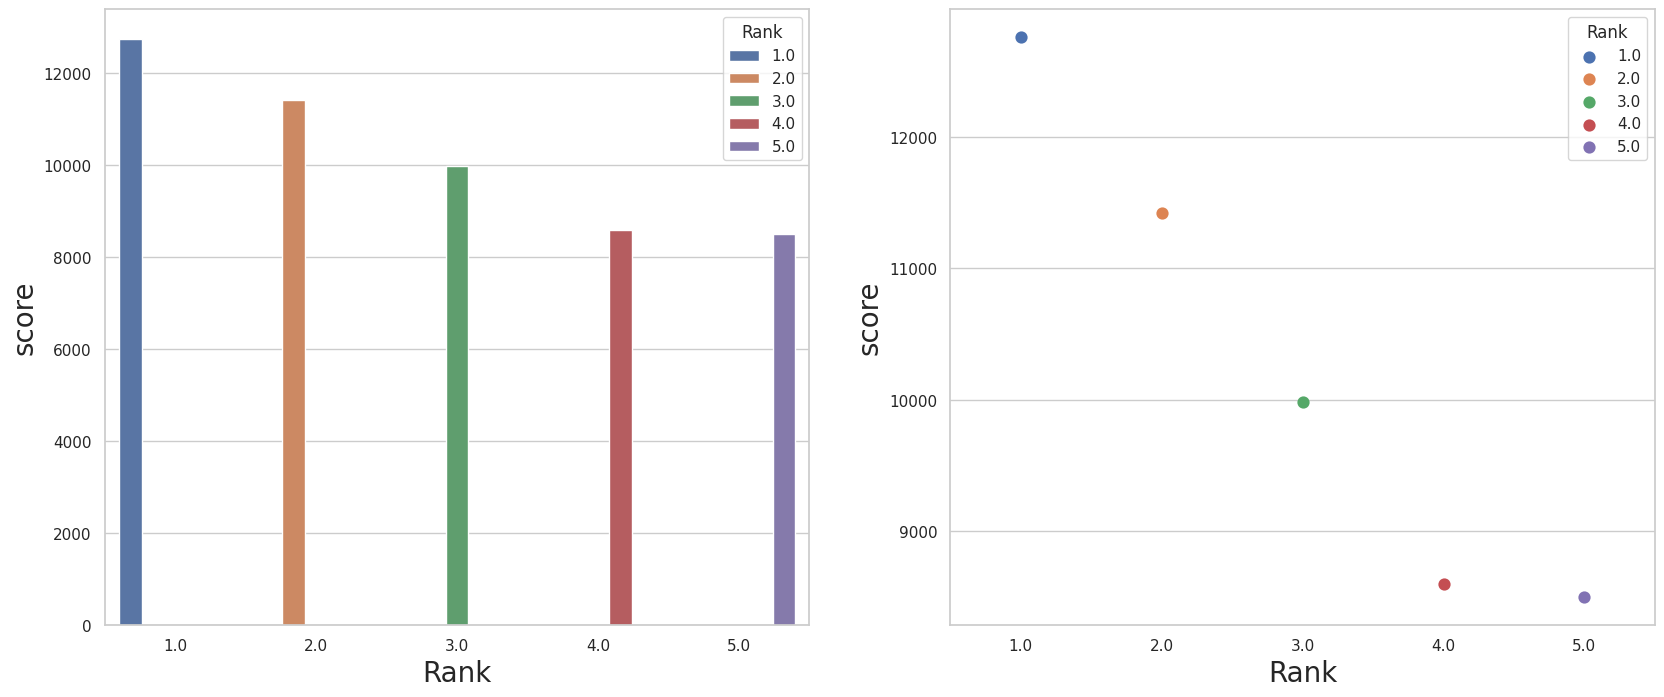

In [ ]:
result_user3 = pr.recommend('A169NZ5I5UQLRY')
result_user3

In [ ]:
#function to display dataframes side by side
from IPython.display import display_html
def display_side_by_side(args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline;margin-left:50px !important;margin-right: 40px !important"'),raw=True)



In [ ]:
display_side_by_side([result_user1, result_user2, result_user3])

,user_id,productId,score,Rank
271616,A1H8PY3QHMQQA0,B0074BW614,12758,1.0
375273,A1H8PY3QHMQQA0,B00DR0PDNE,11418,2.0
287906,A1H8PY3QHMQQA0,B007WTAJTO,9982,3.0
91705,A1H8PY3QHMQQA0,B0019EHU8G,8599,4.0
261349,A1H8PY3QHMQQA0,B006GWO5WK,8498,5.0
,user_id,productId,score,Rank
271616,A1JLEDHBYBOLG2,B0074BW614,12758,1.0
375273,A1JLEDHBYBOLG2,B00DR0PDNE,11418,2.0
287906,A1JLEDHBYBOLG2,B007WTAJTO,9982,3.0
91705,A1JLEDHBYBOLG2,B0019EHU8G,8599,4.0


In [ ]:
# Before calling mean_squared_error, let's add some checks:


pred_ratings = []
for data in test_data.values:
    item_id = data[1]
    user_rating = products.get(item_id, 0)  # Default to np.nan if item_id is not found
    pred_ratings.append(user_rating)


print("Type of test_data['Rating']:", type(test_data['Rating']))
print("Type of pred_ratings:", type(pred_ratings))

print("Length of test_data['Rating']:", len(test_data['Rating']))
print("Length of pred_ratings:", len(pred_ratings))

# Let's check the first few entries to see if they are scalar values
print("First few actual ratings:", test_data['Rating'].head())
print("First few predicted ratings:", pred_ratings[:5])

# Ensure pred_ratings is indeed a flat list
pred_ratings = np.array(pred_ratings).flatten()
print("Shape of flattened pred_ratings:", pred_ratings.shape)

# Now let's try calling mean_squared_error again
mse = mean_squared_error(test_data['Rating'], pred_ratings)

Type of test_data['Rating']: <class 'pandas.core.series.Series'>
Type of pred_ratings: <class 'list'>
Length of test_data['Rating']: 2347345
Length of pred_ratings: 2347345
First few actual ratings: 221257     4.0
4158082    3.0
2588662    2.0
5176853    5.0
5527984    5.0
Name: Rating, dtype: float64
First few predicted ratings: [0, 0, 0, 0, 0]
Shape of flattened pred_ratings: (2347345,)


In [ ]:
pr.predict_evaluate()

1.4892860246191937

<a id="a7a4"></a>
### Observations

Since this is a popularity-based recommender model, we are getting the same result for all three users i.e. the model is recommending the same products for all the users.**.